

# Motor imagery decoding from EEG data using the Common Spatial Pattern (CSP)

Decoding of motor imagery applied to EEG data decomposed using CSP. A
classifier is then applied to features extracted on CSP-filtered signals.

See [CSP wikipedia page](https://en.wikipedia.org/wiki/Common_spatial_pattern) and  [Koles1991](https://doi.org/10.1016/0013-4694(91)90163-X).  
The EEGBCI dataset is documented in [SchalkEtAl2004](http://doi:10.1109/TBME.2004.827072)  and is available at [PhysioNet](https://physionet.org/content/eegmmidb/1.0.0/), [GoldbergerEtAl2000](https://doi.org/10.1161/01.CIR.101.23.e215).  

- Author: Mauro Abidal Carrer <mauroabidal@yahoo.fr>  
- Orginal Authors: Martin Billinger <martin.billinger@tugraz.at>  
- Original script: https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html  
- License: BSD-3-Clause  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations, set_log_level
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
import mne
import mne.decoding

# #############################################################################
# # Set parameters and read data

# Avoid classification of evoked responses by using epochs that start 1s after cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=0, feet=1)
subject = 1
runs = [6, 10, 14]  # Runs indices of motor imagery: hands vs feet

set_log_level(verbose=False)
print('Loading Physionet recordings...', end='')

raw_fnames = eegbci.load_data(subject, runs)                                # -Get paths to edf files.
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]) # -Load(read_raw_edf) in memomry(preloard=True) recprdings and convcatenate them.
eegbci.standardize(raw)  # set channel names                                # -Not sure what this does but it's necessary...
raw.set_montage(make_standard_montage("standard_1005"))                     # -Specify to MNE what montage/setup was used during the recording.
                                                                            #  "standard_1005" refers to a standardized way of placing electrodes on the testee.
                                                                            #  See https://en.wikipedia.org/wiki/10%E2%80%9320_system_(EEG).
print(' done.')              

print(f'Applying band-pass filter, frequency range: [{7.0}, {30.0}]...', end='')
raw.filter(7.0, 30.0, skip_by_annotation="edge")                            # -Apply bandpass filter, only keep frequecies in the range 7-30 Hz.
events, _ = events_from_annotations(raw, event_id=dict(T1=0, T2=1))         # -Make events from annotaions, only use T1 and T2 annotations. Mark them as 0 and 1 respectively.
                                                                            #  According to the Physionet EEG-MI dataset web page(https://physionet.org/content/eegmmidb/1.0.0/),
                                                                            #  T0 corresponds to the motion of both fists and T1 to the motion of both feet.
print(' done.')              

print('Creating epochs from raw data...', end='')

picks = pick_types(raw.info, eeg=True)                                      # -Specify that we only want to listen to the EEG channels, the other channels are set to False by default.
# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)

print(' done.')

Loading Physionet recordings... done.
Applying band-pass filter, frequency range: [7.0, 30.0]... done.
Creating epochs from raw data... done.


Classification with linear discrimant analysis

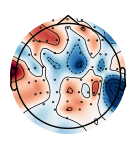

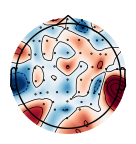

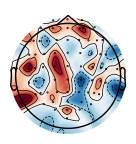

normal filters:


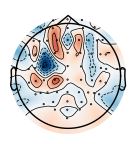

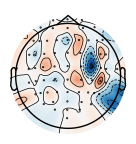

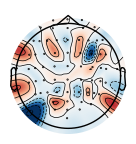

Classification accuracy: 0.9111111111111112.



In [2]:
epochs_data_train = epochs.get_data(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1]

from my_CSP import MyCSP

cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
N_COMPONENTS=4
mne_csp = mne.decoding.CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
csp = MyCSP()

# mne_csp.fit(epochs_data_train, labels)
csp.fit(epochs_data_train, labels)

# mne_csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
_ = csp.plot_patterns(epochs.info)
# plot_topomap(my_csp.patterns_, epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)
# print('mn csp:\n', mne_csp.filters_[: N_COMPONENTS])
# print('mn csp:\n', my_csp.filters_[: N_COMPONENTS])

lda = LinearDiscriminantAnalysis()

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("csp", csp), ("lda", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)
print(f"Classification accuracy: {np.mean(scores)}.\n")

# clf.fit(epochs_data_train, labels)                                                            #-Apperently, cross_val_score doesn't fit the model passed as argument.
# _ = clf['csp'].plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)     #-Assign the returned value to an ignored variable to prevent the chart from getting shown twice.

Look at performance over time



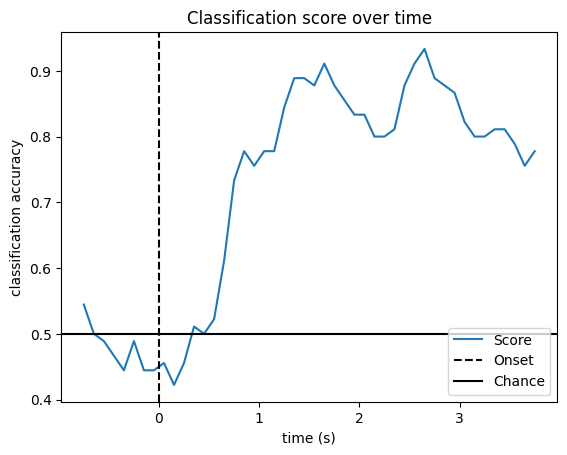

In [3]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
epochs_data = epochs.get_data()
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()